In [15]:
import numpy as np
from typing import List, Tuple

In [5]:
class RFAClient:
    def __init__(self, client_id: int, data_x: np.ndarray, data_y: np.ndarray, learning_rate: float = 0.01):
        self.id = client_id
        self.data_x = data_x
        self.data_y = data_y
        self.learning_rate = learning_rate
        self.n_samples = len(data_y)
        
    def train(self, global_model: np.ndarray, local_epochs: int = 5, batch_size: int = 32) -> np.ndarray:
        model = np.copy(global_model)
        for _ in range(local_epochs):
            indices = np.random.permutation(self.n_samples)
            for batch_start in range(0, self.n_samples, batch_size):
                batch_idx = indices[batch_start:batch_start + batch_size]
                X_batch = self.data_x[batch_idx]
                y_batch = self.data_y[batch_idx]
                # Compute gradient (MSE loss for linear regression)
                predictions = X_batch.dot(model)
                error = predictions - y_batch
                grad = X_batch.T.dot(error) / len(batch_idx)
                # Update model
                model -= self.learning_rate * grad
        return model

In [7]:
class RFAServer:
    def __init__(self, n_features: int, nu: float = 1e-6, max_aggregation_iters: int = 10, tol: float = 1e-6):
        self.global_model = np.zeros(n_features)
        self.nu = nu
        self.max_iters = max_aggregation_iters
        self.tol = tol
        self.history = {
            'global_model': [],
            'aggregation_weights': [],
            'client_updates': []
        }
        
    def geometric_median(self, points: List[np.ndarray], weights: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        points = np.array(points)
        weights = np.array(weights) / sum(weights)  # Normalize weights
        # Initialize with weighted average
        median = np.average(points, axis=0, weights=weights)
        prev_median = np.copy(median)
        for _ in range(self.max_iters):
            # Compute distances from current median
            residuals = points - median
            distances = np.linalg.norm(residuals, axis=1)
            # Compute weights with smoothing
            weights_agg = weights / np.maximum(self.nu, distances)
            # Normalize
            weights_agg /= weights_agg.sum()
            median = np.sum(weights_agg[:, np.newaxis] * points, axis=0)
            if np.linalg.norm(median - prev_median) < self.tol:
                break
            prev_median = np.copy(median)
        return median, weights_agg
    
    def aggregate(self, client_updates: List[np.ndarray], client_weights: List[float]) -> np.ndarray:
        # Compute geometric median
        global_model, agg_weights = self.geometric_median(client_updates, client_weights)
        self.history['global_model'].append(global_model)
        self.history['aggregation_weights'].append(agg_weights)
        self.history['client_updates'].append(client_updates)
        return global_model
    
    def update_global_model(self, global_model: np.ndarray):
        # Update the global model parameters
        self.global_model = global_model

In [9]:
def generate_synthetic_data(n_clients: int = 10, n_features: int = 20, 
                           n_samples_per_client: int = 100, 
                           noise_std: float = 0.1, corruption_frac: float = 0.2) -> Tuple[List[RFAClient], np.ndarray]:
    true_model = np.random.randn(n_features)
    # Create clients
    clients = []
    n_corrupted = int(n_clients * corruption_frac)
    for i in range(n_clients):
        X = np.random.randn(n_samples_per_client, n_features)
        if i < n_corrupted:
            # Corrupted clients return random updates
            y = np.random.randn(n_samples_per_client)
        else:
            # Normal clients
            y = X.dot(true_model) + noise_std * np.random.randn(n_samples_per_client)
        clients.append(RFAClient(i, X, y))
    return clients, true_model

In [11]:
def run_rfa_experiment(n_clients: int = 20, n_features: int = 10, 
                       rounds: int = 100, clients_per_round: int = 5, 
                       local_epochs: int = 3, batch_size: int = 32,
                       corruption_frac: float = 0.3):
    clients, true_model = generate_synthetic_data(
        n_clients, n_features, 
        corruption_frac=corruption_frac
    )
    server = RFAServer(n_features)
    for round_idx in range(rounds):
        selected_clients = np.random.choice(clients, clients_per_round, replace=False)
        updates = []
        weights = []
        for client in selected_clients:
            update = client.train(server.global_model, local_epochs, batch_size)
            updates.append(update)
            weights.append(client.n_samples)
        # Robust aggregation
        global_model = server.aggregate(updates, weights)
        server.update_global_model(global_model)
        # Calculate error
        error = np.linalg.norm(server.global_model - true_model)
        if round_idx % 10 == 0:
            print(f"Round {round_idx:3d} | Error: {error:.4f}")
    return server, clients, true_model

In [13]:
def analyze_results(server: RFAServer, true_model: np.ndarray):
    # Analyze and visualize RFA results
    import matplotlib.pyplot as plt
    errors = [np.linalg.norm(model - true_model) for model in server.history['global_model']]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(errors)
    plt.xlabel('Communication Round')
    plt.ylabel('Model Error')
    plt.title('Convergence')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    weights = np.array(server.history['aggregation_weights'])
    plt.boxplot(weights.T)
    plt.xlabel('Client Index')
    plt.ylabel('Aggregation Weight')
    plt.title('Weight Distribution')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Final error
    final_error = np.linalg.norm(server.global_model - true_model)
    print(f"Final model error: {final_error:.4f}")

Round   0 | Error: 3.1744
Round  10 | Error: 1.7900
Round  20 | Error: 1.0096
Round  30 | Error: 0.3605
Round  40 | Error: 0.1326
Round  50 | Error: 0.5472
Round  60 | Error: 0.2139
Round  70 | Error: 0.0874
Round  80 | Error: 0.1510
Round  90 | Error: 0.2738


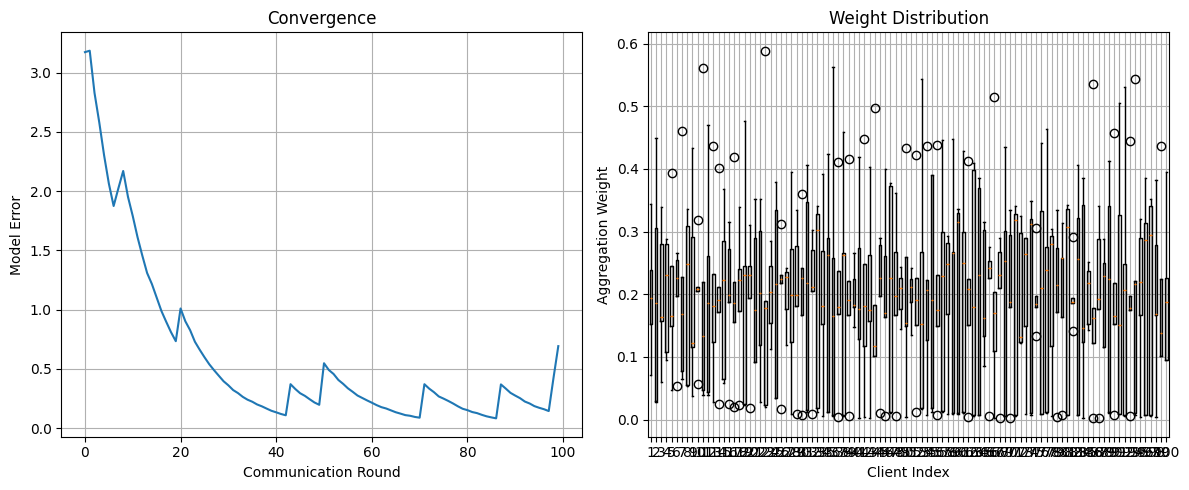

Final model error: 0.6916


In [17]:
if __name__ == "__main__":
    # RFA
    server, clients, true_model = run_rfa_experiment(
        n_clients=20,
        n_features=10,
        rounds=100,
        clients_per_round=5,
        corruption_frac=0.3  # 30% Byzantine clients
    )
    # Analyze results
    analyze_results(server, true_model)

Round   0 | Parameter error: 2.4112
Round  10 | Parameter error: 1.4144
Round  20 | Parameter error: 1.5597
Round  30 | Parameter error: 1.4604
Round  40 | Parameter error: 1.7452
Round  50 | Parameter error: 1.3565
Round  60 | Parameter error: 1.1213
Round  70 | Parameter error: 0.9533
Round  80 | Parameter error: 0.9205
Round  90 | Parameter error: 1.3688


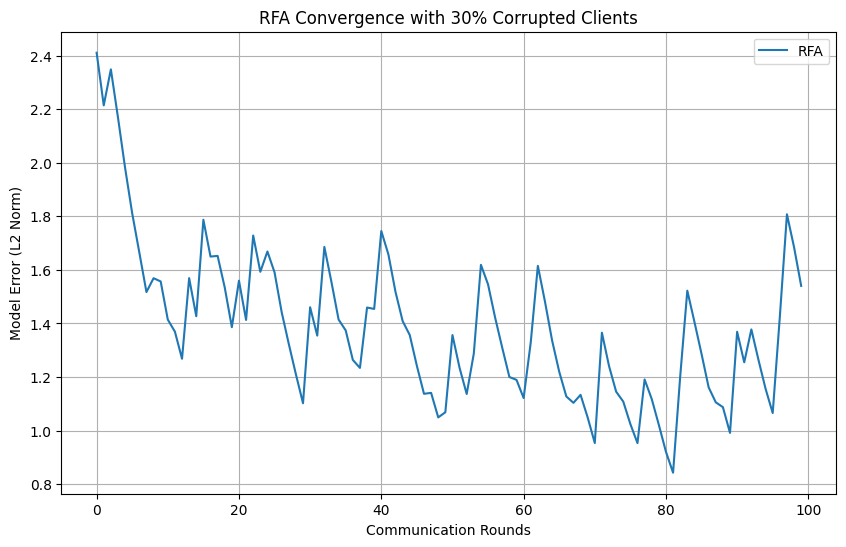

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class RFAClient:
    def __init__(self, data_x, data_y, learning_rate):
        self.data_x = data_x
        self.data_y = data_y
        self.learning_rate = learning_rate
        
    def train(self, global_model, steps):
        """Perform local SGD training"""
        model = np.copy(global_model)
        for _ in range(steps):
            grad = self.compute_gradient(model)
            model -= self.learning_rate * grad
        return model
    
    def compute_gradient(self, model):
        """Compute MSE gradient for linear regression"""
        predictions = self.data_x.dot(model)
        error = predictions - self.data_y
        return self.data_x.T.dot(error) / len(self.data_y)

class RFAServer:
    def __init__(self, clients, model_dim, nu=1e-6, aggregation_iters=3):
        self.clients = clients
        self.global_model = np.zeros(model_dim)
        self.nu = nu
        self.aggregation_iters = aggregation_iters
    
    def select_clients(self, num_clients):
        """Random client selection without replacement"""
        return np.random.choice(self.clients, num_clients, replace=False)
    
    def geometric_median(self, points, alphas):
        """Smoothed Weiszfeld algorithm (Algorithm 2 from paper)"""
        points = np.array(points)
        alphas = np.array(alphas) / np.sum(alphas)  # Normalize weights
        
        # Initialize with weighted average
        median = np.average(points, axis=0, weights=alphas)
        
        for _ in range(self.aggregation_iters):
            # Compute distances and handle numerical stability
            residuals = points - median
            distances = np.linalg.norm(residuals, axis=1)
            weights = alphas / np.maximum(self.nu, distances)
            
            # Update estimate (secure aggregation would happen here)
            new_median = np.sum(weights[:, None] * points, axis=0) / np.sum(weights)
            
            # Check for convergence
            if np.linalg.norm(new_median - median) < 1e-6:
                break
            median = new_median
        
        return median
    
    def train_round(self, clients_per_round, local_steps):
        """Complete one round of RFA training (Algorithm 1 from paper)"""
        selected_clients = self.select_clients(clients_per_round)
        updates = []
        alphas = []
        
        # Client update phase
        for client in selected_clients:
            local_model = client.train(self.global_model, local_steps)
            updates.append(local_model)
            alphas.append(len(client.data_x))  # Weight by data size
        
        # Robust aggregation phase
        self.global_model = self.geometric_median(updates, alphas)

def generate_synthetic_data(num_clients=10, model_dim=5, data_std=0.1, corruption_ratio=0.3):
    """Generate synthetic dataset with optional corrupted clients"""
    true_model = np.random.randn(model_dim)
    clients = []
    
    for i in range(num_clients):
        n_samples = np.random.randint(50, 200)
        X = np.random.randn(n_samples, model_dim)
        
        if i < num_clients * corruption_ratio:
            # Create corrupted client (label flipping + noise injection)
            y = -X.dot(true_model) + data_std * np.random.randn(n_samples)
        else:
            y = X.dot(true_model) + data_std * np.random.randn(n_samples)
        
        clients.append(RFAClient(X, y, learning_rate=0.01))
    
    return clients, true_model

def run_experiment():
    # Experiment configuration
    config = {
        'model_dim': 5,
        'num_clients': 20,
        'rounds': 100,
        'clients_per_round': 5,
        'local_steps': 10,
        'corruption_ratio': 0.3,  # 30% corrupted clients
        'data_std': 0.1
    }
    
    # Initialize components
    clients, true_model = generate_synthetic_data(
        config['num_clients'],
        config['model_dim'],
        config['data_std'],
        config['corruption_ratio']
    )
    server = RFAServer(clients, config['model_dim'])
    
    # Training metrics storage
    errors = []
    
    # Training loop
    for r in range(config['rounds']):
        server.train_round(config['clients_per_round'], config['local_steps'])
        
        # Calculate error to true model
        error = np.linalg.norm(server.global_model - true_model)
        errors.append(error)
        
        if r % 10 == 0:
            print(f"Round {r:3d} | Parameter error: {error:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(errors, label='RFA')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Model Error (L2 Norm)')
    plt.title('RFA Convergence with 30% Corrupted Clients')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_experiment()

Round   0 | Errors: {'fedavg': '4.1845', 'rfa': '4.1482', 'one-step': '4.1999', 'personalized': '4.1488'}
Round  10 | Errors: {'fedavg': '3.9814', 'rfa': '2.6853', 'one-step': '3.9737', 'personalized': '2.6870'}
Round  20 | Errors: {'fedavg': '4.0134', 'rfa': '1.7646', 'one-step': '3.9705', 'personalized': '1.7707'}
Round  30 | Errors: {'fedavg': '4.0609', 'rfa': '1.1774', 'one-step': '3.9778', 'personalized': '1.1855'}
Round  40 | Errors: {'fedavg': '4.0150', 'rfa': '0.8015', 'one-step': '3.9798', 'personalized': '0.8096'}
Round  50 | Errors: {'fedavg': '4.0610', 'rfa': '0.5550', 'one-step': '3.9839', 'personalized': '0.5642'}
Round  60 | Errors: {'fedavg': '4.0185', 'rfa': '0.3952', 'one-step': '3.9771', 'personalized': '0.4006'}
Round  70 | Errors: {'fedavg': '4.0529', 'rfa': '0.2868', 'one-step': '3.9807', 'personalized': '0.2918'}
Round  80 | Errors: {'fedavg': '4.0210', 'rfa': '0.2139', 'one-step': '3.9787', 'personalized': '0.2171'}
Round  90 | Errors: {'fedavg': '4.0860', 'rfa'

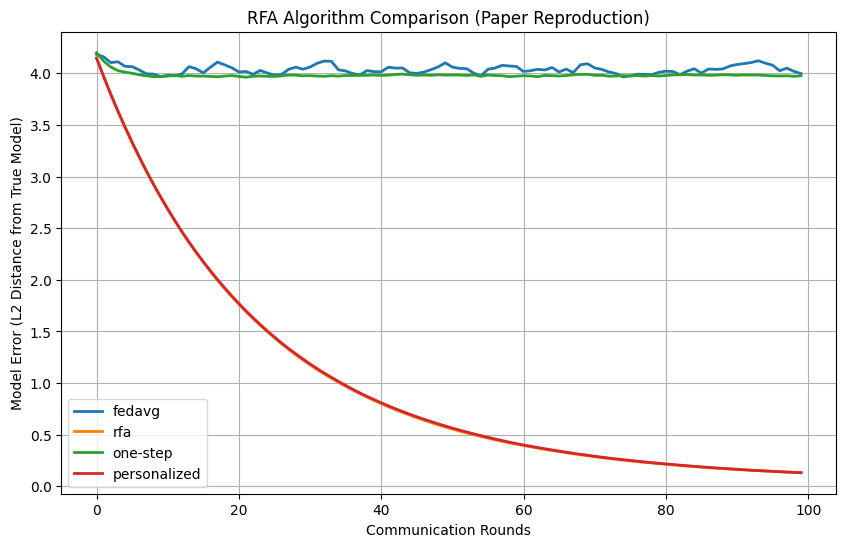

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

# --------------------------
# Core Algorithm Implementations
# --------------------------

class RFAAggregator:
    """Implements all aggregation strategies from the paper"""

    @staticmethod
    def fedavg(updates, weights):
        return np.average(updates, axis=0, weights=weights)

    @staticmethod
    def smoothed_weiszfeld(updates, weights, nu=1e-6, max_iter=100, tol=1e-6):
        updates = np.array(updates)
        weights = np.array(weights) / sum(weights)
        v = np.average(updates, axis=0, weights=weights)

        for _ in range(max_iter):
            residuals = updates - v
            distances = np.linalg.norm(residuals, axis=1)
            weights_iter = weights / np.maximum(nu, distances)
            weights_iter /= weights_iter.sum()
            new_v = np.sum(weights_iter[:, None] * updates, axis=0)
            if np.linalg.norm(new_v - v) < tol:
                break
            v = new_v

        return v

    @staticmethod
    def one_step_rfa(updates, weights, nu=1e-6):
        norms = np.linalg.norm(updates, axis=1)
        weights = weights / np.maximum(nu, norms)
        weights /= weights.sum()
        return np.average(updates, axis=0, weights=weights)

    @staticmethod
    def personalized_aggregate(global_updates, weights, nu=1e-6):
        return RFAAggregator.smoothed_weiszfeld(global_updates, weights, nu)

# --------------------------
# Client Implementations
# --------------------------

class BaseClient(ABC):
    def __init__(self, client_id, data, model_dim, learning_rate):
        self.id = client_id
        self.X, self.y = data
        self.model_dim = model_dim
        self.lr = learning_rate

    @abstractmethod
    def compute_update(self, global_model):
        pass

class StandardClient(BaseClient):
    def compute_update(self, global_model):
        w = global_model.copy()
        self.local_steps = 5
        for _ in range(self.local_steps):
            grad = self._compute_gradient(w)
            w -= self.lr * grad
        return w

    def _compute_gradient(self, model):
        return self.X.T @ (self.X @ model - self.y) / len(self.y)

class PersonalizedClient(BaseClient):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.personal_params = np.random.randn(self.model_dim) * 0.01

    def compute_update(self, global_model):
        self.personal_steps = 5
        self.global_steps = 5

        combined_model = global_model + self.personal_params
        for _ in range(self.personal_steps):
            grad = self._compute_gradient(combined_model)
            self.personal_params -= self.lr * grad

        global_grads = []
        current_global = global_model.copy()
        for _ in range(self.global_steps):
            combined_model = current_global + self.personal_params
            grad = self._compute_gradient(combined_model)
            current_global -= self.lr * grad
            global_grads.append(grad)

        return np.mean(global_grads, axis=0)

    def _compute_gradient(self, model):
        return self.X.T @ (self.X @ model - self.y) / len(self.y)

class CorruptedClient(StandardClient):
    def __init__(self, corruption_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.corruption_type = corruption_type

    def compute_update(self, global_model):
        clean_update = super().compute_update(global_model)
        if self.corruption_type == "random":
            return np.random.randn(*clean_update.shape)
        elif self.corruption_type == "inverted":
            return -clean_update
        elif self.corruption_type == "gaussian":
            return clean_update + np.random.randn(*clean_update.shape) * np.std(clean_update)
        return clean_update

# --------------------------
# Server Implementation
# --------------------------

class RFAServer:
    def __init__(self, model_dim, aggregator='rfa', nu=1e-6):
        self.global_model = np.zeros(model_dim)
        self.aggregator = aggregator
        self.nu = nu
        self.history = []

    def aggregate_updates(self, updates, weights):
        if self.aggregator == 'fedavg':
            return RFAAggregator.fedavg(updates, weights)
        elif self.aggregator == 'rfa':
            return RFAAggregator.smoothed_weiszfeld(updates, weights, self.nu)
        elif self.aggregator == 'one-step':
            return RFAAggregator.one_step_rfa(updates, weights, self.nu)
        elif self.aggregator == 'personalized':
            return RFAAggregator.personalized_aggregate(updates, weights, self.nu)
        else:
            raise ValueError(f"Unknown aggregator: {self.aggregator}")

    def train_round(self, clients, corruption_level=0.0):
        updates = []
        weights = []
        corrupted_indices = []

        num_corrupted = int(len(clients) * corruption_level)
        corrupt_indices = np.random.choice(len(clients), num_corrupted, replace=False)

        for i, client in enumerate(clients):
            if i in corrupt_indices and isinstance(client, CorruptedClient):
                update = client.compute_update(self.global_model)
                corrupted_indices.append(i)
            else:
                update = client.compute_update(self.global_model)

            updates.append(update)
            weights.append(len(client.y))

        weights = np.array(weights) / sum(weights)
        self.global_model = self.aggregate_updates(updates, weights)

        self.history.append({
            'updates': updates,
            'weights': weights,
            'corrupted': corrupted_indices
        })

# --------------------------
# Synthetic Data Generation
# --------------------------

def generate_synthetic_data(num_clients, model_dim, corruption=0.0, personalization=0.0):
    base_model = np.random.randn(model_dim)
    clients = []

    for i in range(num_clients):
        n_samples = np.random.randint(50, 200)
        X = np.random.randn(n_samples, model_dim)

        if personalization > 0 and np.random.rand() < 0.5:
            true_model = base_model + np.random.randn(model_dim) * personalization
        else:
            true_model = base_model

        y = X @ true_model + np.random.normal(0, 0.1, n_samples)

        if np.random.rand() < corruption:
            clients.append(CorruptedClient(
                corruption_type=np.random.choice(["random", "inverted", "gaussian"]),
                client_id=i,
                data=(X, y),
                model_dim=model_dim,
                learning_rate=0.01
            ))
        else:
            clients.append(StandardClient(
                client_id=i,
                data=(X, y),
                model_dim=model_dim,
                learning_rate=0.01
            ))

    return clients, base_model

# --------------------------
# Experiment Framework
# --------------------------

def run_experiment(config):
    clients, true_model = generate_synthetic_data(
        config['num_clients'],
        config['model_dim'],
        corruption=config['corruption_level'],
        personalization=config['personalization_strength']
    )

    servers = {
        alg: RFAServer(config['model_dim'], aggregator=alg)
        for alg in ['fedavg', 'rfa', 'one-step', 'personalized']
    }

    results = {alg: [] for alg in servers}

    for round in range(config['num_rounds']):
        for alg, server in servers.items():
            server.train_round(clients, config['corruption_level'])
            error = np.linalg.norm(server.global_model - true_model)
            results[alg].append(error)

        if round % 10 == 0:
            errors_str = {alg: f"{results[alg][-1]:.4f}" for alg in servers}
            print(f"Round {round:3d} | Errors: {errors_str}")

    plt.figure(figsize=(10, 6))
    for alg, errors in results.items():
        plt.plot(errors, label=alg, linewidth=2)

    plt.title("RFA Algorithm Comparison (Paper Reproduction)")
    plt.xlabel("Communication Rounds")
    plt.ylabel("Model Error (L2 Distance from True Model)")
    plt.grid(True)
    plt.legend()
    plt.show()

# --------------------------
# Example Usage
# --------------------------

if __name__ == "__main__":
    experiment_config = {
        'num_clients': 100,
        'model_dim': 20,
        'num_rounds': 100,
        'corruption_level': 0.3,
        'personalization_strength': 0.2
    }
    run_experiment(experiment_config)